# **Analys The Problem**

Previously on papper "Facial Expression Recognition Methods in the Wild Based on Fusion Feature of Attention Mechanism and LBP (MDPI Sensors 2023 Q2)" authors used a model called ResNet-50 combined CBAM and LBP.

The accuracy took:
- 99.66% on CK+
- 74.23% on FER-2013
- 89.50 on FER-PLUS 
- 88.20 on RAF-DB

**The problem: What if I change the variant of LBP in this method, does it increase the accuracy spesifically for FER-2013 dataset?**

# **About Dataset**

- The paper used 4 dataset include CK+(59 images), FER-2013 (35,887 images), FER-PLUS(31.412 images), RAF-DB (29,672 images)
- CK+ is a controlled dataset and the 3 others datasets are uncontrolled datasets
- Controlled dataset has good lightning and pose but uncontrolled datasets got a random of it

# **Method**

## Paper's Method

- **ResNet-18 + CBAM**

    1. Architecture of ResNet-18:
    
        <img src="../src/Structure-of-a-ResNet-18-architecture.png" alt="Windowing of Feature in Faces" width="350" height="250">

    2. CBAM Architecture:

        <img src="../src/cbam.png" alt="Windowing of Feature in Faces" width="600" height="100">

    3. Authors combine the CBAM module into each block of the ResNet-18 architecture,
    
        Before and After implement the CBAM module:

        <img src="../src/oriblock.png" alt="Windowing of Feature in Faces" width="150" height="200">
        <img src="../src/blocknCbam.png" alt="Windowing of Feature in Faces" width="150" height="200">

- **Local Binary Patterns (LBP)**

    LBP is one of the most generally used texture pattern descriptors for examining local grain features and is regarded as one of the best methods for texture processing, which is widely employed in image processing.

- **RCL-Net Model**

    After combining all the method such as LBP and ResNet-CBAM, this architecture called by **RCL-Net Model**,

    <img src="../src/rcl-net.png" alt="Windowing of Feature in Faces" width="700" height="200">



## Proposed Method

- In planning, switching LBP method in previous architecture with the newest or other variant LBP

# **IMPORT LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

# for augmen:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.transforms as T

# for mixup augmen:
import torch
import random

# mixup from train.py file
import argparse
import os
import sys

# LBP
import cv2
import torch.nn as nn
import math

from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
import mlflow
import mlflow.pytorch

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from skimage.feature import local_binary_pattern

from torchvision.models import resnet18
import torch.nn.functional as F

d:\Ando File 4 Kuliah\A SKRIPSI\RISETku\KERJA\CODE\venv\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
print(torch.cuda.is_available())

True


# **DATA LOADING**

- Making dataframe:

In [42]:
# Baca file CSV
# file_path_train = 'D:/Ando File 4 Kuliah/A SKRIPSI/RISETku/KERJA/DATA/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv'  # Ganti dengan lokasi file kamu
# df_train = pd.read_csv(file_path_train)

# file_path_test = 'D:/Ando File 4 Kuliah/A SKRIPSI/RISETku/KERJA/DATA/challenges-in-representation-learning-facial-expression-recognition-challenge/test.csv'  # Ganti dengan lokasi file kamu
# df_test = pd.read_csv(file_path_test)

file_path = 'D:/Ando File 4 Kuliah/A SKRIPSI/RISETku/KERJA/DATA/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv'  # Ganti dengan lokasi file kamu
df = pd.read_csv(file_path)

- Visualize the data on datatables:

In [43]:
df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


# **PREPROCESSING**

## Resized Image 100 x 100:

- Define function resized:

In [44]:
# Fungsi untuk mengubah string pixel menjadi gambar
def convert_to_image(pixels, size=(48, 48), new_size=(100, 100)):
    # Ubah string pixel menjadi array
    pixel_values = np.array(pixels.split(), dtype=np.uint8)
    
    # Ubah array 1D menjadi array 2D
    image = pixel_values.reshape(size)
    
    # Buat gambar dari array 2D
    img = Image.fromarray(image)
    
    # Ubah ukuran gambar menggunakan LANCZOS untuk kualitas terbaik
    resized_img = img.resize(new_size, Image.Resampling.LANCZOS)
    
    return resized_img

- Processing the resize to all images and saved to new dataframe:

In [45]:
df_resized = pd.DataFrame(columns=['emotion', 'usage', 'resized_pixels']) # DataFrame baru untuk menyimpan gambar yang sudah diproses

# Proses setiap baris di DataFrame asli dengan progress bar
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing Images"):
    pixels = row[' pixels']
    
    # Konversi pixel menjadi gambar dan resize
    resized_image = convert_to_image(pixels)
    
    # Ubah gambar yang diresize menjadi array 1D untuk disimpan dalam DataFrame
    resized_image_array = np.array(resized_image).flatten()
    
    # Buat DataFrame baru untuk baris ini
    new_row = pd.DataFrame({
        'emotion': [row['emotion']],
        'usage': [row[' Usage']],
        'resized_pixels': [' '.join(resized_image_array.astype(str))]
    })
    
    # Gabungkan baris baru dengan DataFrame yang sudah ada
    df_resized = pd.concat([df_resized, new_row], ignore_index=True)

Processing Images: 100%|██████████| 35887/35887 [04:02<00:00, 147.76it/s]


- Checking info of dataset:

In [46]:
df_resized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   emotion         35887 non-null  object
 1   usage           35887 non-null  object
 2   resized_pixels  35887 non-null  object
dtypes: object(3)
memory usage: 841.2+ KB


In [47]:
df_resized.head()

,emotion,usage,resized_pixels
0,0,Training,69 71 77 84 86 84 80 72 64 59 57 57 57 58 61 6...
1,0,Training,151 151 151 149 147 148 152 155 153 148 144 13...
2,2,Training,230 232 227 205 173 154 153 166 178 175 154 13...
3,4,Training,23 25 28 34 37 36 32 29 31 32 28 23 20 19 18 2...
4,6,Training,6 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


Checking column's names:

In [48]:
df_resized.columns

Index(['emotion', 'usage', 'resized_pixels'], dtype='object')

Checking unique value in "Usage" columnns:

In [49]:
df_resized['usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

Separating between train, public, and private test:

In [50]:
# Filter data yang Usage-nya "Training"
df_train = df_resized[df_resized['usage'] == 'Training']
df_public_test = df_resized[df_resized['usage'] == 'PublicTest']
df_private_test = df_resized[df_resized['usage'] == 'PrivateTest']

- Checking total of row and column:

In [51]:
print(df_train.shape)
print(df_public_test.shape)
print(df_private_test.shape)

(28709, 3)
(3589, 3)
(3589, 3)


- Before Resized 48x48:

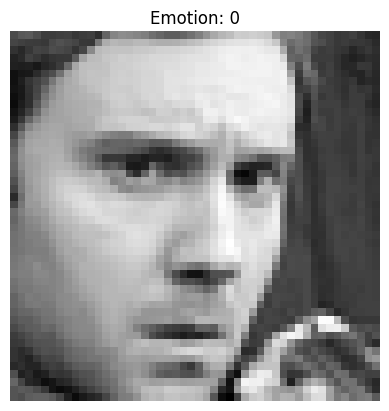

In [52]:
# Ambil data pixels dari baris yang diinginkan
row_index = 0  # Ganti dengan indeks baris yang diinginkan
pixels = df[' pixels'][row_index]

# Ubah string pixel menjadi array 1D
pixel_values = np.array(pixels.split(), dtype=np.uint8)

# Ubah array 1D menjadi array 2D
image = pixel_values.reshape(48, 48)

# Tampilkan gambar
plt.imshow(image, cmap='gray')
plt.title(f"Emotion: {df['emotion'][row_index]}")
plt.axis('off')  # Hilangkan sumbu
plt.show()

- After resized 100x100:

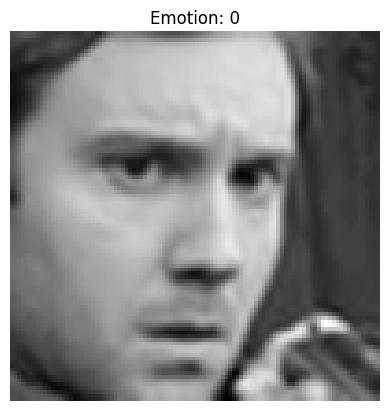

In [53]:
# Ambil data pixels dari baris yang diinginkan
row_index = 0  # indeks baris yang diinginkan
pixels = df_resized['resized_pixels'][row_index]

# Ubah string pixel menjadi array 1D
pixel_values = np.array(pixels.split(), dtype=np.uint8)

# Ubah array 1D menjadi array 2D (100x100)
image = pixel_values.reshape(100, 100)

# Tampilkan gambar
plt.imshow(image, cmap='gray')
plt.title(f"Emotion: {df_resized['emotion'][row_index]}")
plt.axis('off')  # Hilangkan sumbu
plt.show()

Menerapkan minimum data:

In [54]:
# Menghitung total data per label pada kolom 'emotion'
label_counts = df_train.groupby('emotion').size()

# Menampilkan hasil
print(label_counts)

emotion
0    3995
1     436
2    4097
3    7215
4    4830
5    3171
6    4965
dtype: int64


In [55]:
df_train

,emotion,usage,resized_pixels
0,0,Training,69 71 77 84 86 84 80 72 64 59 57 57 57 58 61 6...
1,0,Training,151 151 151 149 147 148 152 155 153 148 144 13...
2,2,Training,230 232 227 205 173 154 153 166 178 175 154 13...
3,4,Training,23 25 28 34 37 36 32 29 31 32 28 23 20 19 18 2...
4,6,Training,6 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
...,...,...,...
28704,2,Training,84 84 85 85 85 85 85 85 85 85 85 85 85 85 85 8...
28705,0,Training,114 114 113 112 112 113 114 114 113 111 111 11...
28706,4,Training,72 75 78 83 86 87 87 88 91 95 98 100 100 98 93...
28707,0,Training,220 223 225 229 224 189 127 83 76 88 92 90 89 ...


In [56]:
# Tentukan jumlah data yang diinginkan per label
desired_count = 436

# List untuk menyimpan DataFrame setiap label setelah disampling
balanced_dataframes = []

# Loop untuk setiap label di kolom 'emotion'
for label, group in df_train.groupby('emotion'):
#     print(f"Label: {label}, Group: {len(group)}")
        if len(group) > desired_count:
#       # Jika jumlah data lebih dari desired_count, lakukan undersampling
                sampled_group = group.sample(n=desired_count, random_state=42)
        else:
#         # Jika jumlah data kurang atau sama dengan desired_count, gunakan semua data
                sampled_group = group
    
#     # Tambahkan data yang telah disampling ke dalam list
        balanced_dataframes.append(sampled_group)

# # Gabungkan semua data yang telah diundersampling menjadi satu DataFrame
df_balanced_train = pd.concat(balanced_dataframes)

# # Menampilkan total data per label setelah undersampling
print(df_balanced_train.groupby('emotion').size())

emotion
0    436
1    436
2    436
3    436
4    436
5    436
6    436
dtype: int64


In [57]:
# Reset indeks setelah melakukan sampling atau filtering
df_balanced_train = df_balanced_train.reset_index(drop=True)

In [58]:
df_balanced_train.head()

,emotion,usage,resized_pixels
0,0,Training,136 129 115 100 89 79 67 53 37 26 25 29 33 35 ...
1,0,Training,25 23 18 17 22 29 34 34 31 26 25 24 22 24 32 4...
2,0,Training,229 226 222 216 214 212 212 211 213 215 218 22...
3,0,Training,220 223 225 229 224 189 127 83 76 88 92 90 89 ...
4,0,Training,71 79 93 108 108 92 64 42 41 52 63 71 76 78 83...


In [59]:
df_balanced_train.shape

(3052, 3)

## Augmantation

- Define augmentation function:

In [60]:
# Fungsi augmentasi
def augment_image(image):
    # Pipeline augmentasi menggunakan albumentations
    transform = A.Compose([
        A.RandomCrop(width=95, height=95),         # Random crop ukuran 80x80 dari gambar asli (100x100)
        A.HorizontalFlip(p=1),                   # Membalik gambar secara horizontal dengan probabilitas 100%
        A.Rotate(limit=20, p=1),                 # Memutar gambar dengan sudut hingga 20 derajat
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=1),  # Jitter warna
        A.CoarseDropout(max_holes=4, max_height=5, max_width=5, p=1),  # Random masking
        A.Resize(100, 100),                        # Resize kembali menjadi ukuran 100x100
        # A.Normalize(mean=(0.5,), std=(0.5,)),      # Dibuatr normalize 0,1 agar bentuknya kembali semula kalo ini dihilangkan outputnya pecah, gak jadi ini setelah augmentasi
        ToTensorV2()                               # Ubah gambar menjadi tensor PyTorch
    ])
    
    augmented = transform(image=image)
    return augmented['image']

- Processing the augmentation:

In [61]:
# List untuk menyimpan hasil augmentasi
augmented_images = []
augmented_emotions = []

# Proses augmentasi untuk setiap gambar di dataframe asli
for i in tqdm(range(len(df_balanced_train)), desc="Augmenting images"):
    # Ambil gambar dari dataframe dan ubah menjadi array 2D
    pixels = np.array(df_balanced_train['resized_pixels'][i].split(), dtype=np.uint8).reshape(100, 100)
    
    # Augmentasi gambar
    augmented_image = augment_image(pixels)
    
    # Ubah tensor augmented_image kembali ke numpy array, lalu ubah jadi string lagi untuk disimpan di dataframe
    augmented_image_np = augmented_image.permute(1, 2, 0).numpy().flatten().tolist()  # Ubah ke list 1D
    augmented_image_str = ' '.join(map(str, augmented_image_np))  # Ubah list jadi string
    
    # Simpan gambar yang sudah di-augmentasi dan emosi ke list
    augmented_images.append(augmented_image_str)
    augmented_emotions.append(df_balanced_train['emotion'][i])

# Masukkan hasil augmentasi ke dataframe baru
augmented_df_train = pd.DataFrame({
    'emotion': augmented_emotions,
    'resized_pixels': augmented_images
})

Augmenting images: 100%|██████████| 3052/3052 [00:16<00:00, 185.96it/s]


In [62]:
augmented_df_train

,emotion,resized_pixels
0,0,14 12 15 23 32 42 48 46 40 32 30 30 31 37 44 4...
1,0,44 37 33 36 38 35 25 19 19 21 22 22 24 25 26 2...
2,0,17 22 22 21 26 31 38 44 44 36 22 7 1 6 14 16 1...
3,0,131 133 135 139 140 141 142 143 144 145 147 14...
4,0,40 42 45 53 65 84 95 86 66 53 56 72 86 93 94 9...
...,...,...
3047,6,5 4 1 1 0 0 0 1 2 4 7 9 9 8 5 2 0 1 3 8 11 10 ...
3048,6,0 0 0 0 0 0 0 2 7 11 16 25 37 52 64 74 82 88 9...
3049,6,23 33 39 40 38 42 51 65 75 76 60 39 32 34 31 2...
3050,6,255 255 255 255 234 187 149 133 122 109 110 13...


- Visualize Before Augmentation

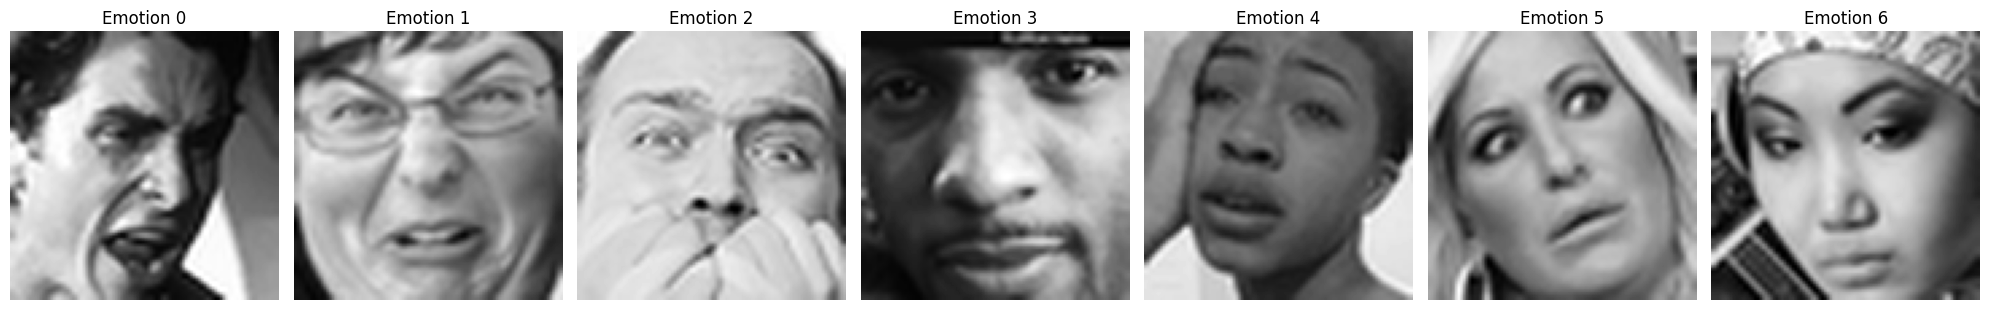

In [63]:
# Ambil satu sampel gambar dari masing-masing kategori emosi
before_sampled_df = df_balanced_train.groupby('emotion').first().reset_index()

# Function to convert pixel string to image
def convert_to_image(pixel_str):
    pixels = np.array(pixel_str.split(), dtype='float32')  # Convert string to float array
    return pixels.reshape(100, 100)  # Reshape sesuai ukuran gambar 100x100

# Plotting the images in a grid
fig, axes = plt.subplots(1, 7, figsize=(20, 5))

for idx, row in enumerate(before_sampled_df.itertuples()):
    img = convert_to_image(row.resized_pixels)
    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(f'Emotion {row.emotion}')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

- Visualize image after augmentation:

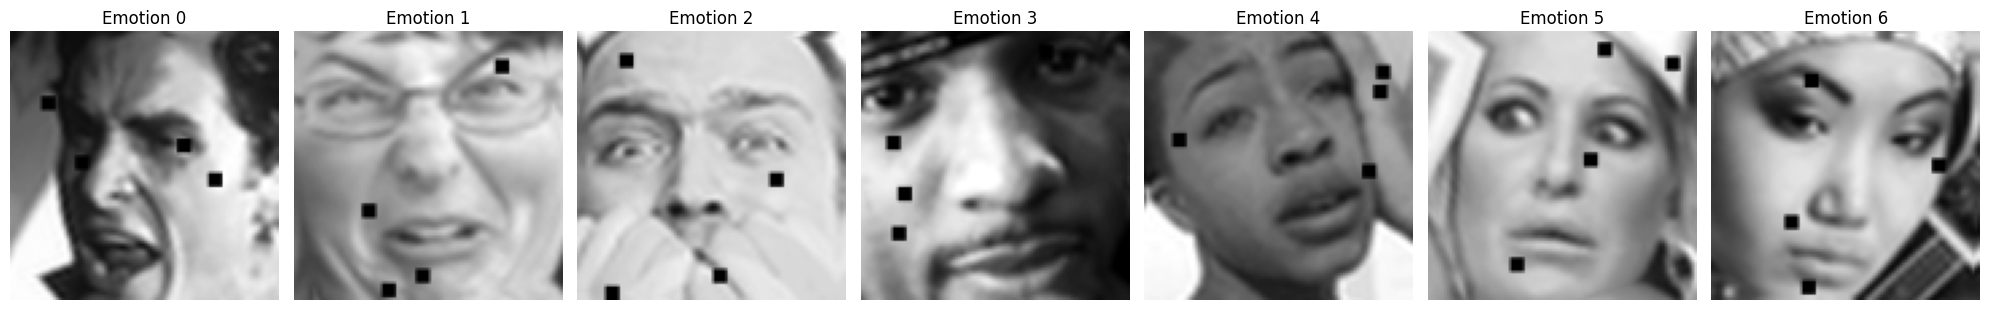

In [64]:
# Ambil satu sampel gambar dari masing-masing kategori emosi
after_sampled_df = augmented_df_train.groupby('emotion').first().reset_index()

# Function to convert pixel string to image
def convert_to_image(pixel_str):
    pixels = np.array(pixel_str.split(), dtype='float32')  # Convert string to float array
    return pixels.reshape(100, 100)  # Reshape sesuai ukuran gambar 100x100

# Plotting the images in a grid
fig, axes = plt.subplots(1, 7, figsize=(20, 5))

for idx, row in enumerate(after_sampled_df.itertuples()):
    img = convert_to_image(row.resized_pixels)
    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(f'Emotion {row.emotion}')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

- Append the new augmentation into original dataframe before the augmentation:

In [65]:
# Gabungkan dataframe asli dengan dataframe augmented
df_combined_train = pd.concat([df_balanced_train, augmented_df_train], ignore_index=True)

In [66]:
# Tampilkan informasi jumlah data
print(f"Jumlah data setelah augmentasi: {len(df_combined_train)}")

# Tampilkan contoh baris dari dataframe gabungan
print(df_combined_train.head())

Jumlah data setelah augmentasi: 6104
  emotion     usage                                     resized_pixels
0       0  Training  136 129 115 100 89 79 67 53 37 26 25 29 33 35 ...
1       0  Training  25 23 18 17 22 29 34 34 31 26 25 24 22 24 32 4...
2       0  Training  229 226 222 216 214 212 212 211 213 215 218 22...
3       0  Training  220 223 225 229 224 189 127 83 76 88 92 90 89 ...
4       0  Training  71 79 93 108 108 92 64 42 41 52 63 71 76 78 83...


- Define function normalize pixel to [0,1] dividing by 255:

In [67]:
# Fungsi untuk normalisasi nilai piksel
def normalize_pixels(pixels):
    # Ubah string pixel menjadi array float
    pixel_values = np.array(pixels.split(), dtype=np.float32)
    
    # Bagi setiap nilai piksel dengan 255 untuk menormalisasi ke [0,1]
    normalized_pixel_values = pixel_values / 255.0
    
    # Ubah kembali array menjadi string agar sesuai dengan format dataframe
    return ' '.join(map(str, normalized_pixel_values))

- Proceeding the normalize to all row:

In [68]:
# Terapkan normalisasi dengan progress bar
tqdm.pandas()  # Untuk menambahkan kemampuan progress bar pada pandas

# Normalisasi pada kolom 'resized_pixels' dengan progress bar
df_combined_train['resized_pixels'] = df_combined_train['resized_pixels'].progress_apply(normalize_pixels)

100%|██████████| 6104/6104 [00:38<00:00, 158.61it/s]


In [69]:
# Terapkan normalisasi dengan progress bar
tqdm.pandas()  # Untuk menambahkan kemampuan progress bar pada pandas

# Normalisasi pada kolom 'resized_pixels' dengan progress bar
# Menggunakan .loc[] untuk mengubah kolom secara aman
df_public_test.loc[:, 'resized_pixels'] = df_public_test['resized_pixels'].progress_apply(normalize_pixels)

100%|██████████| 3589/3589 [00:22<00:00, 156.55it/s]


In [72]:
# # Simpan DataFrame ke file CSV baru
# df_combined_train.to_csv('afterAugTrain.csv', index=False)  # index=False untuk tidak menyimpan index baris
# df_public_test.to_csv('afterAugTest.csv', index=False)  # index=False untuk tidak menyimpan index baris

In [3]:
df_combined_train = pd.read_csv('afterAugTrain.csv')
df_public_test = pd.read_csv('afterAugTest.csv')

- Visualize datatable:

In [4]:
# Tampilan hasil original + augmentasi dataframe setelah normalisasi
df_combined_train.head()

,emotion,usage,resized_pixels
0,0,Training,0.53333336 0.5058824 0.4509804 0.39215687 0.34...
1,0,Training,0.09803922 0.09019608 0.07058824 0.06666667 0....
2,0,Training,0.8980392 0.8862745 0.87058824 0.84705883 0.83...
3,0,Training,0.8627451 0.8745098 0.88235295 0.8980392 0.878...
4,0,Training,0.2784314 0.30980393 0.3647059 0.42352942 0.42...


In [5]:
# Tampilan hasil df_public_test dataframe setelah normalisasi
df_public_test.head()

,emotion,usage,resized_pixels
0,0,PublicTest,0.00390619 0.00390619 0.00390619 0.00390619 0....
1,1,PublicTest,0.00236832 0.002475971 0.002675894 0.002906574...
2,4,PublicTest,0.00092272204 0.0012302961 0.0016916571 0.0017...
3,6,PublicTest,0.0032602844 0.0031372549 0.0029680892 0.00316...
4,3,PublicTest,0.0013225683 0.0013071896 0.0012610535 0.00121...


Kolom emotion: Jika ini adalah label kelas, awalnya tipe object maka bisa mengubahnya menjadi tipe data numerik menggunakan LabelEncoder dari scikit-learn:

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_combined_train['emotion'] = le.fit_transform(df_combined_train['emotion'])

Kolom resized_pixels: Jika kolom ini berisi string yang merepresentasikan array alias saat ini tipe object, maka perlu mengubahnya menjadi array numpy:

In [7]:
# Konversi string piksel menjadi array NumPy data train
df_combined_train['resized_pixels'] = df_combined_train['resized_pixels'].apply(
    lambda x: np.fromstring(x, sep=' ').astype(np.float32).reshape(100, 100)
)

In [8]:
df_combined_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6104 entries, 0 to 6103
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   emotion         6104 non-null   int64 
 1   usage           3052 non-null   object
 2   resized_pixels  6104 non-null   object
dtypes: int64(1), object(2)
memory usage: 143.2+ KB


In [9]:
# Konversi string piksel menjadi array NumPy data test
df_public_test.loc[:, 'resized_pixels'] = df_public_test['resized_pixels'].apply(
    lambda x: np.fromstring(x, sep=' ').astype(np.float32).reshape(100, 100)
)

In [10]:
# Pastikan semua entri memiliki ukuran 100x100
print(df_combined_train['resized_pixels'].apply(lambda x: x.shape == (100, 100)).all())
print(df_public_test['resized_pixels'].apply(lambda x: x.shape == (100, 100)).all())

True
True


In [11]:
# Tampilkan informasi dataframe setelah normalisasi
df_combined_train.head()

,emotion,usage,resized_pixels
0,0,Training,"[[0.53333336, 0.5058824, 0.4509804, 0.39215687..."
1,0,Training,"[[0.09803922, 0.09019608, 0.07058824, 0.066666..."
2,0,Training,"[[0.8980392, 0.8862745, 0.87058824, 0.84705883..."
3,0,Training,"[[0.8627451, 0.8745098, 0.88235295, 0.8980392,..."
4,0,Training,"[[0.2784314, 0.30980393, 0.3647059, 0.42352942..."


In [12]:
# Tampilkan informasi dataframe setelah normalisasi
df_public_test.head()

,emotion,usage,resized_pixels
0,0,PublicTest,"[[0.00390619, 0.00390619, 0.00390619, 0.003906..."
1,1,PublicTest,"[[0.00236832, 0.002475971, 0.002675894, 0.0029..."
2,4,PublicTest,"[[0.00092272204, 0.0012302961, 0.0016916571, 0..."
3,6,PublicTest,"[[0.0032602844, 0.0031372549, 0.0029680892, 0...."
4,3,PublicTest,"[[0.0013225683, 0.0013071896, 0.0012610535, 0...."


# PERCOBAAN MODEL II

- Data Loading

In [13]:
import torch
from torch.utils.data import Dataset

class EmotionDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame berisi data gambar yang sudah di-resize
            transform (callable, optional): Transformasi yang ingin diterapkan ke gambar
        """
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        # Mengembalikan jumlah data dalam dataset
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Mengambil gambar dan label dari dataframe pada index yang diberikan
        image = self.dataframe.iloc[idx]['resized_pixels']
        label = self.dataframe.iloc[idx]['emotion']
        
        # Konversi gambar menjadi tensor
        image = torch.tensor(image, dtype=torch.float32)

        # Kalau diperlukan, ubah ukuran image menjadi 1x100x100 (karena greyscale)
        image = image.unsqueeze(0)  # Menambahkan dimensi channel (1 untuk grayscale)

        # Terapkan transformasi jika ada
        if self.transform:
            image = self.transform(image)

        return image, label

In [14]:
# Membuat instance dari EmotionDataset
train_dataset = EmotionDataset(df_combined_train)
test_dataset = EmotionDataset(df_public_test)

In [15]:
from torch.utils.data import DataLoader

# Menggunakan DataLoader untuk batch processing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

- CBAM Module

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)


# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), "kernel size must be 3 or 7"
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)


# CBAM Block
class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        out = self.ca(x) * x
        out = self.sa(out) * out
        return out

In [17]:
# CBAM Module sudah terdefinisi di atas
class BasicBlockWithCBAM(nn.Module):
    def __init__(self, original_block, in_planes):
        super(BasicBlockWithCBAM, self).__init__()
        self.original_block = original_block
        self.cbam = CBAM(in_planes)  # Tambahkan CBAM ke BasicBlock

    def forward(self, x):
        x = self.original_block(x)  # BasicBlock orisinil
        x = self.cbam(x)  # Tambahkan CBAM setelah output dari block
        return x

- lbp

In [18]:
def lbp_feature_extraction_batch(batch_images, radius=1, n_points=8):
    """
    Mengekstraksi fitur LBP dari batch gambar.
    
    Parameters:
    - batch_images: Tensor batch gambar dengan dimensi (batch_size, channels, height, width)
    - radius: Jarak radius dari pusat pixel untuk LBP.
    - n_points: Jumlah poin di sekitar radius.
    
    Returns:
    - lbp_features: Array numpy berisi fitur LBP untuk setiap gambar dalam batch.
    """
    lbp_features_list = []
    
    # Loop melalui setiap gambar di batch
    for image in batch_images:
        # Cek apakah gambar adalah tensor PyTorch
        if isinstance(image, torch.Tensor):
            # Pindahkan tensor ke CPU, hilangkan channel dimension (1, H, W), dan ubah menjadi numpy array
            image_np = image.squeeze(0).cpu().numpy()  # Hilangkan channel dimension jika ada (grayscale)
        else:
            image_np = image  # Jika sudah dalam format numpy, tidak perlu diubah lagi
        
        # Pastikan gambar adalah 2D
        if len(image_np.shape) != 2:
            raise ValueError(f"Expected 2D image, got {image_np.shape}")
        
        # Hitung LBP untuk setiap gambar (input harus 2D)
        lbp_image = local_binary_pattern(image_np, n_points, radius, method='uniform')

        # Hitung histogram LBP sebagai fitur
        (hist, _) = np.histogram(lbp_image.ravel(),
                                 bins=np.arange(0, n_points + 3),
                                 range=(0, n_points + 2))
        
        # Normalisasi histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)  # Tambahkan epsilon untuk mencegah pembagian dengan 0

        # Simpan fitur histogram ke dalam list
        lbp_features_list.append(hist)
    
    # Gabungkan semua fitur ke dalam satu array numpy
    lbp_features_batch = np.array(lbp_features_list)
    return lbp_features_batch

In [19]:
# # Contoh input: batch gambar grayscale dengan ukuran (64, 1, 100, 100)
# x = torch.randn(64, 1, 100, 100)  # Batch berisi 64 gambar, masing-masing 100x100

# # Ekstrak fitur LBP dari batch
# lbp_features = lbp_feature_extraction_batch(x)

# # Cek bentuk fitur LBP setelah diekstrak
# print(f"Shape of LBP features: {lbp_features.shape}")

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

# Assuming you have implemented CBAM and LBP feature extraction as functions or classes

# Load pretrained ResNet18
model = resnet18(pretrained=True)

# Modify the first convolution layer to accept grayscale input
model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)  # For grayscale input

# Remove the maxpool layer (optional, based on your architecture description)
model.maxpool = nn.Identity()

# Modify layer2, layer3, and layer4 blocks to include CBAM
# Assuming BasicBlockWithCBAM is a custom class
model.layer2[0] = BasicBlockWithCBAM(model.layer2[0], 128)
model.layer2[1] = BasicBlockWithCBAM(model.layer2[1], 128)

model.layer3[0] = BasicBlockWithCBAM(model.layer3[0], 256)
model.layer3[1] = BasicBlockWithCBAM(model.layer3[1], 256)

model.layer4[0] = BasicBlockWithCBAM(model.layer4[0], 512)
model.layer4[1] = BasicBlockWithCBAM(model.layer4[1], 512)

# Remove the fully connected layer for ImageNet classification
model.fc = nn.Identity()  # Remove the original fc (ImageNet classifier)

# Fully connected layers for ResNet-CBAM branch (global features)
model.fc1 = nn.Linear(512, 7)  # FC layer for global features

# LBP branch fully connected layer
model.fc2 = nn.Linear(256, 7)  # FC layer for local features (LBP)

# Fully connected layer for fused features
model.fc3 = nn.Linear(14, 7)  # FC3: Concatenated features will be of size 14

# Forward pass function for feature fusion and classification
def forward_pass(x):
    # ResNet-CBAM branch (global feature extraction)
    x_resnet = model(x)  # Pass input image through ResNet-CBAM

    # Flatten the ResNet-CBAM output
    x_resnet = x_resnet.view(x_resnet.size(0), -1)  # Flatten the features to (batch_size, 512)

    # Pass through FC1 for ResNet-CBAM branch (global features)
    fa = F.relu(model.fc1(x_resnet))  # FC1 output is of size 7
    
    # **LBP feature extraction**
    lbp_features = lbp_feature_extraction_batch(x.cpu().numpy())  # Ekstrak fitur LBP (di CPU)
    lbp_features = torch.from_numpy(lbp_features).float().to(x.device)  # Konversi ke tensor PyTorch dan pindahkan ke device
    lbp_features = lbp_features.view(lbp_features.size(0), -1)  # Flatten jika perlu

    # Process LBP features through fully connected layers
    fl = F.relu(model.fc2(lbp_features))  # FC2 output is of size 7

    # Fuse global (FA) and local (FL) features
    fv = torch.cat((fa, fl), dim=1)  # Concatenate FA and FL along the feature dimension (size 14)

    # Final classification through FC3
    output = model.fc3(fv)  # FC3: Output is 7 (classification categories)

    # Return the log softmax (for classification)
    return F.log_softmax(output, dim=1)

# Example usage with a dummy input
x = torch.randn(1, 1, 224, 224)  # Example input image (grayscale, 224x224)
lbp_features = torch.randn(1, 256)  # Example LBP features

# Run the model in evaluation mode
model.eval()

# # Get the output from the forward pass
# output = forward_pass(x)
# print(output)


d:\Ando File 4 Kuliah\A SKRIPSI\RISETku\KERJA\CODE\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Ando File 4 Kuliah\A SKRIPSI\RISETku\KERJA\CODE\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [21]:
# Pindahkan model ke GPU jika ada
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [22]:
device

device(type='cuda')

In [23]:
torch.cuda.empty_cache()  # Bersihkan cache CUDA

# Training

In [24]:
# Fungsi untuk memvisualisasikan confusion matrix
def save_confusion_matrix(y_true, y_pred, epoch, save_path):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(7), yticklabels=range(7))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - Epoch {epoch+1}')
    plt.savefig(os.path.join(save_path, f'confusion_matrix_best.png'))
    plt.close()

In [25]:
# Cek apakah ada checkpoint
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint['best_val_acc']

In [26]:
# Fungsi untuk menghitung metrik evaluasi
def calculate_metrics(outputs, labels):
    _, preds = torch.max(outputs, 1)
    labels = labels.cpu().numpy()
    preds = preds.cpu().numpy()

    precision = precision_score(labels, preds, average='weighted', zero_division=1)
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    
    return precision, recall, f1

In [27]:
# Optimizer SGD dengan learning rate, momentum, dan weight decay yang ditentukan
optimizer = optim.SGD(model.parameters(), lr=0.9, momentum=0.1, weight_decay=0.0001)

# Loss function: Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# Untuk memulai training dari checkpoint
start_epoch = 0
num_epochs = 300
best_val_acc = 0.0
save_path = './checkpoints'

# Jika ingin melanjutkan dari checkpoint
resume = False  # Ganti ke True jika ingin melanjutkan dari checkpoint
if resume and os.path.exists(os.path.join(save_path, 'best_model.pth')):
    start_epoch, best_val_acc = load_checkpoint(os.path.join(save_path, 'best_model.pth'))
    print(f"Resuming training from epoch {start_epoch+1} with best validation accuracy {best_val_acc:.4f}")

# Early stopping initialization
early_stop_count = 0
max_early_stop = 30

# Training loop dengan checkpoint dan evaluasi metrik
for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Progress bar untuk training
    train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Training)", leave=False)

    for inputs, labels in train_progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass through ResNet-CBAM and LBP branches
        outputs = forward_pass(inputs)

        # Compute loss
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        train_acc = correct / total
        train_progress_bar.set_postfix(acc=train_acc, loss=loss.item())

    train_loss = running_loss / len(train_loader)

    # Validasi
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_labels = []
    all_outputs = []

    val_progress_bar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)", leave=False)

    with torch.no_grad():
        for inputs, labels in val_progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # **LBP feature extraction for validation**
            lbp_features = lbp_feature_extraction_batch(inputs).to(device)
            
            # Forward pass through ResNet-CBAM and LBP branches
            outputs = model(inputs, lbp_features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

    val_acc = val_correct / val_total
    val_loss = val_loss / len(test_loader)

    precision, recall, f1 = calculate_metrics(torch.tensor(all_outputs), torch.tensor(all_labels))

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Simpan model terbaik berdasarkan akurasi validasi
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_checkpoint_path = os.path.join(save_path, 'best_model.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc
        }, best_checkpoint_path)
        print(f"Best model saved at epoch {epoch+1} with validation accuracy {val_acc:.4f}")

        # Simpan confusion matrix untuk epoch terbaik
        save_confusion_matrix(all_labels, torch.argmax(torch.tensor(all_outputs), axis=1).numpy(), epoch, save_path)
        print(f"Confusion matrix saved for best epoch {epoch+1}")
        
        early_stop_count = 0  # Reset early stop count saat model membaik
    else:
        early_stop_count += 1
        print(f"Early stop count increased to {early_stop_count}")

    # Simpan checkpoint setiap 10 epoch
    if (epoch + 1) % 10 == 0:
        checkpoint_path = os.path.join(save_path, f'checkpoint_epoch_{epoch+1}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc
        }, checkpoint_path)
        print(f"Checkpoint saved for epoch {epoch+1}")

    # Early stopping
    if early_stop_count >= max_early_stop:
        print(f"Training stopped early at epoch {epoch+1}")
        break


ValueError: Expected 2D image, got (1, 100, 100)

# Mixup Augmentation

- Define function Mixup image and labels:

In [134]:
# def mixup_images_labels(images, labels, alpha=0.2):
#     """Menerapkan Mixup Augmentation pada dua gambar dan label.
    
#     Args:
#         images (tensor): Tensor gambar-gambar dengan shape (batch_size, channels, height, width).
#         labels (tensor): Tensor one-hot encoded label dengan shape (batch_size, num_classes).
#         alpha (float): Parameter distribusi Beta untuk campuran.

#     Returns:
#         mixed_images: Gambar campuran.
#         mixed_labels: Label campuran.
#     """
#     # Ambil nilai lambda dari distribusi Beta
#     lambda_val = np.random.beta(alpha, alpha)
    
#     # Pilih dua indeks acak
#     index = torch.randperm(images.size(0))
    
#     # Gabungkan dua gambar
#     mixed_images = lambda_val * images + (1 - lambda_val) * images[index, :]
    
#     # Gabungkan label
#     mixed_labels = lambda_val * labels + (1 - lambda_val) * labels[index, :]
    
#     return mixed_images, mixed_labels


- Define function for data preparation before mixup: 

In [168]:
# # Pastikan gambar dalam format tensor dan normalisasi ke [0, 1]
# def prepare_images_labels(df):
#     images = []
#     labels = []

#     for i in tqdm(range(len(df))):
#         # Ambil pixel dan konversi ke array numpy
#         pixels = np.array(df['resized_pixels'][i].split(), dtype=np.float32).reshape(100, 100) / 255.0
        
#         # Tambahkan channel dimension untuk tensor (1 channel karena grayscale)
#         images.append(pixels[np.newaxis, :, :])
        
#         # Ambil label (ekspresi) dan ubah menjadi one-hot encoding
#         label = df['emotion'][i]
#         one_hot_label = np.zeros(8)  # Misal 8 kelas ekspresi
#         one_hot_label[label] = 1
#         labels.append(one_hot_label)

#     # Ubah list ke tensor
#     images = torch.tensor(np.array(images), dtype=torch.float32)
#     labels = torch.tensor(np.array(labels), dtype=torch.float32)
    
#     return images, labels

In [170]:
# # Persiapkan gambar dan label dari combined_df
# images, labels = prepare_images_labels(df_combined_train)

100%|██████████| 6104/6104 [00:30<00:00, 201.94it/s]


- Processing Mixup Augmentation:

In [171]:
# # Batch size untuk Mixup Augmentation
# batch_size = 64  # Batch size 64

# # Acak gambar dan label untuk setiap batch
# for i in tqdm(range(0, len(images), batch_size)):
#     batch_images = images[i:i+batch_size]
#     batch_labels = labels[i:i+batch_size]
    
#     # Terapkan Mixup Augmentation
#     mixed_images, mixed_labels = mixup_images_labels(batch_images, batch_labels, alpha=0.4)

# # (Selanjutnya, mixed_images dan mixed_labels dapat digunakan untuk training model)

100%|██████████| 96/96 [00:00<00:00, 507.37it/s]


- Visualize the result of mixup augmented:

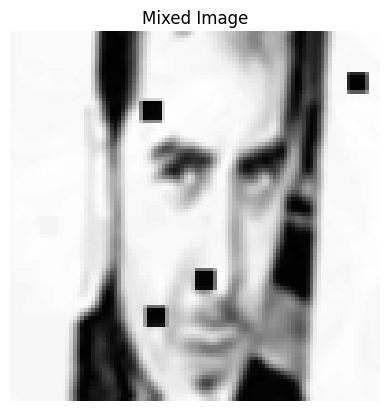

In [177]:
# mixed_image = mixed_images[2, 0]  # Ambil gambar pertama dari saluran pertama

# # Ubah tensor ke numpy array
# image = mixed_image.detach().numpy()  # Mengubah tensor menjadi numpy array

# # Denormalisasi jika perlu, misal dari rentang [-1, 1] ke [0, 255]
# image = (image * 0.5 + 0.5) * 255  # Skala ulang ke [0, 255]

# # Pastikan untuk mengubah tipe data menjadi uint8
# image = (image * 255).astype(np.uint8)

# # Tampilkan gambar
# plt.imshow(image, cmap='gray')
# plt.axis('off')  # Hilangkan sumbu
# plt.title("Mixed Image")
# plt.show()


# MODELING

Konversi DataFrame ke Tensor:

In [35]:
class EmotionDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # image = torch.tensor(self.dataframe['resized_pixels'].iloc[idx], dtype=torch.float32).view(1, 100, 100)  # Jika gambar 100x100
        # label = torch.tensor(self.dataframe['emotion'].iloc[idx], dtype=torch.long)
        image = torch.tensor(self.dataframe['resized_pixels'].iloc[idx], dtype=torch.float32).unsqueeze(0)  # Sudah 100x100, hanya tambah channel dimension
        label = torch.tensor(self.dataframe['emotion'].iloc[idx], dtype=torch.long)
        return image, label


Membuat DataLoader:

In [36]:
# Inisialisasi dataset
train_dataset = EmotionDataset(df_combined_train)
test_dataset = EmotionDataset(df_public_test)

In [37]:


# Inisialisasi DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

LBP circular

In [38]:
# Fungsi untuk mendapatkan intensitas piksel tetangga menggunakan interpolasi bilinear
def get_pixel_value(img, center, x, y):
    # Jika tetangga berada di dalam batas gambar
    if x >= 0 and x < img.shape[0] and y >= 0 and y < img.shape[1]:
        return img[int(x)][int(y)]
    else:
        return center

# Fungsi untuk menghitung Circular LBP pada piksel (x, y)
def lbp_calculated_pixel(img, x, y, radius, neighbors):
    center = img[x][y]
    values = []
    
    # Looping untuk mengambil nilai tetangga dalam pola melingkar
    for n in range(neighbors):
        theta = 2 * math.pi * n / neighbors  # Sudut
        x_n = x + radius * math.sin(theta)   # Koordinat tetangga dalam pola melingkar
        y_n = y + radius * math.cos(theta)
        neighbor_value = get_pixel_value(img, center, x_n, y_n)
        values.append(1 if neighbor_value >= center else 0)
    
    # Menghitung nilai biner LBP
    lbp_value = 0
    for i in range(len(values)):
        lbp_value += values[i] * (1 << i)  # 1 << i adalah 2^i
    
    return lbp_value

# Fungsi untuk menghitung Circular LBP untuk seluruh citra
def calculate_lbp_image(img, radius=1, neighbors=8):
    height, width = img.shape
    lbp_image = np.zeros((height, width), dtype=np.uint32)  # Mengubah tipe data ke uint32 untuk mendukung nilai besar
    
    for i in range(radius, height - radius):
        for j in range(radius, width - radius):
            lbp_image[i, j] = lbp_calculated_pixel(img, i, j, radius, neighbors)
    
    # Normalisasi jika diperlukan (mengembalikan nilai dalam rentang 0-255)
    lbp_image_normalized = np.uint8(lbp_image / lbp_image.max() * 255)
    
    return lbp_image_normalized

# Fungsi untuk menampilkan hasil
# def show_output(original_img, lbp_img):
#     fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
#     # Gambar asli (grayscale)
#     axs[0].imshow(original_img, cmap='gray')
#     axs[0].set_title('Original Grayscale Image')
    
#     # Hasil LBP
#     axs[1].imshow(lbp_img, cmap='gray')
#     axs[1].set_title('Circular LBP Image')
    
#     plt.show()

# Fungsi untuk ekstraksi fitur LBP dari batch gambar
def lbp_feature_extraction_batch(images, radius=3, neighbors=24):
    lbp_features = []
    for img in images:
        lbp_img = calculate_lbp_image(img.squeeze().cpu().numpy(), radius, neighbors)  # Ekstraksi LBP dari gambar
        lbp_hist, _ = np.histogram(lbp_img.ravel(), bins=np.arange(0, neighbors + 3), range=(0, neighbors + 2))
        lbp_hist = lbp_hist.astype("float")
        lbp_hist /= lbp_hist.sum()  # Normalisasi histogram
        lbp_features.append(lbp_hist)

    return np.array(lbp_features)
    
neighbors=24 # samakan dengan tabel dari referensi circular lbp ini yang optimal

# Definisikan ukuran fitur LBP
lbp_feature_size = neighbors + 2  # Misalnya 26 untuk 24 neighbors  

# Main function
# def lbp_feature_extraction(image):
#     # Membaca citra
#     # image_file = '../src/lenna.jpg'
#     image_file = image
#     img_bgr = cv2.imread(image_file)
#     img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
#     # Hitung LBP dengan radius 3 dan 24 tetangga
#     lbp_img = calculate_lbp_image(img_gray, radius=3, neighbors=24)
    
#     # Tampilkan hasilnya
#     show_output(img_gray, lbp_img)

#     return lbp_img

# if __name__ == "__main__":
#     lbp_img = lbp_feature_extraction()


Mengonversi Output LBP menjadi Vektor dan Menghubungkan ke FC Layer:

In [39]:
# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        # MLP
        self.fc1 = nn.Conv2d(in_channels, in_channels // ratio, kernel_size=1, bias=False)
        self.fc2 = nn.Conv2d(in_channels // ratio, in_channels, kernel_size=1, bias=False)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

# CBAM Module (Channel + Spatial Attention)
class CBAM(nn.Module):
    def __init__(self, in_channels, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x


In [40]:
class ResNet18_CBAM(nn.Module):
    def __init__(self, n_classes):
        super(ResNet18_CBAM, self).__init__()
        
        self.dropout_percentage = 0.5
        self.relu = nn.ReLU()
        
        # BLOCK-1 (starting block) input=(224x224) output=(56x56)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(7,7), stride=(2,2), padding=(3,3))
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(1,1))
        
        # CBAM after block1
        self.cbam1 = CBAM(64)

        # BLOCK-2 (1) input=(56x56) output = (56x56)
        self.conv2_1_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_1_1 = nn.BatchNorm2d(64)
        self.conv2_1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_1_2 = nn.BatchNorm2d(64)
        self.dropout2_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-2 (2)
        self.conv2_2_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_2_1 = nn.BatchNorm2d(64)
        self.conv2_2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_2_2 = nn.BatchNorm2d(64)
        self.dropout2_2 = nn.Dropout(p=self.dropout_percentage)
        
        # CBAM after block2
        self.cbam2 = CBAM(64)
        
        # BLOCK-3 (1) input=(56x56) output = (28x28)
        self.conv3_1_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm3_1_1 = nn.BatchNorm2d(128)
        self.conv3_1_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_1_2 = nn.BatchNorm2d(128)
        self.concat_adjust_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1,1), stride=(2,2), padding=(0,0))
        self.dropout3_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-3 (2)
        self.conv3_2_1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_2_1 = nn.BatchNorm2d(128)
        self.conv3_2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_2_2 = nn.BatchNorm2d(128)
        self.dropout3_2 = nn.Dropout(p=self.dropout_percentage)
        
        # CBAM after block3
        self.cbam3 = CBAM(128)

        # BLOCK-4 (1) input=(28x28) output = (14x14)
        self.conv4_1_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm4_1_1 = nn.BatchNorm2d(256)
        self.conv4_1_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_1_2 = nn.BatchNorm2d(256)
        self.concat_adjust_4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(1,1), stride=(2,2), padding=(0,0))
        self.dropout4_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-4 (2)
        self.conv4_2_1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_2_1 = nn.BatchNorm2d(256)
        self.conv4_2_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_2_2 = nn.BatchNorm2d(256)
        self.dropout4_2 = nn.Dropout(p=self.dropout_percentage)
        
        # CBAM after block4
        self.cbam4 = CBAM(256)

        # BLOCK-5 (1) input=(14x14) output = (7x7)
        self.conv5_1_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm5_1_1 = nn.BatchNorm2d(512)
        self.conv5_1_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_1_2 = nn.BatchNorm2d(512)
        self.concat_adjust_5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(1,1), stride=(2,2), padding=(0,0))
        self.dropout5_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-5 (2)
        self.conv5_2_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_2_1 = nn.BatchNorm2d(512)
        self.conv5_2_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_2_2 = nn.BatchNorm2d(512)
        self.dropout5_2 = nn.Dropout(p=self.dropout_percentage)
        
        # CBAM after block5
        self.cbam5 = CBAM(512)
        
        # Final Block input=(7x7) 
        # self.avgpool = nn.AvgPool2d(kernel_size=(7, 7), stride=(7, 7))  # Mengubah output menjadi (512, 1, 1)
        self.avgpool = nn.AvgPool2d(kernel_size=(4, 4), stride=(4, 4))  # Output akan menjadi (512, 1, 1)
        self.fc = nn.Linear(in_features=1 * 1 * 512, out_features=1000)  # 512 dari avgpool
        self.out = nn.Linear(in_features=1000, out_features=n_classes)  # n_classes sesuai dengan jumlah kelas
        # END

    def forward(self, x):
        # block 1 --> Starting block
        x = self.relu(self.batchnorm1(self.conv1(x)))
        op1 = self.maxpool1(x)
        op1 = self.cbam1(op1)
        # print(f"Output after Block 1: {op1.shape}")  # Cek ukuran output
        
        # block2 - 1
        x = self.relu(self.batchnorm2_1_1(self.conv2_1_1(op1)))    # conv2_1 
        x = self.batchnorm2_1_2(self.conv2_1_2(x))                 # conv2_1
        x = self.dropout2_1(x)
        # block2 - Adjust - No adjust in this layer as dimensions are already same
        # block2 - Concatenate 1
        op2_1 = self.relu(x + op1)
        # block2 - 2
        x = self.relu(self.batchnorm2_2_1(self.conv2_2_1(op2_1)))  # conv2_2 
        x = self.batchnorm2_2_2(self.conv2_2_2(x))                 # conv2_2
        x = self.dropout2_2(x)
        # op - block2
        op2 = self.relu(x + op2_1)
        op2 = self.cbam2(op2)
        # print(f"Output after Block 2: {op2.shape}")  # Cek ukuran output
        
        # block3 - 1[Convolution block]
        x = self.relu(self.batchnorm3_1_1(self.conv3_1_1(op2)))    # conv3_1
        x = self.batchnorm3_1_2(self.conv3_1_2(x))                 # conv3_1
        x = self.dropout3_1(x)
        # block3 - Adjust
        op2 = self.concat_adjust_3(op2) # SKIP CONNECTION
        # block3 - Concatenate 1
        op3_1 = self.relu(x + op2)
        # block3 - 2[Identity Block]
        x = self.relu(self.batchnorm3_2_1(self.conv3_2_1(op3_1)))  # conv3_2
        x = self.batchnorm3_2_2(self.conv3_2_2(x))                 # conv3_2 
        x = self.dropout3_2(x)
        # op - block3
        op3 = self.relu(x + op3_1)
        op3 = self.cbam3(op3)
        # print(f"Output after Block 3: {op3.shape}")  # Cek ukuran output

        # block4 - 1[Convolition block]
        x = self.relu(self.batchnorm4_1_1(self.conv4_1_1(op3)))    # conv4_1
        x = self.batchnorm4_1_2(self.conv4_1_2(x))                 # conv4_1
        x = self.dropout4_1(x)
        # block4 - Adjust
        op3 = self.concat_adjust_4(op3) # SKIP CONNECTION
        # block4 - Concatenate 1
        op4_1 = self.relu(x + op3)
        # block4 - 2[Identity Block]
        x = self.relu(self.batchnorm4_2_1(self.conv4_2_1(op4_1)))  # conv4_2
        x = self.batchnorm4_2_2(self.conv4_2_2(x))                 # conv4_2
        x = self.dropout4_2(x)
        # op - block4
        op4 = self.relu(x + op4_1)
        op4 = self.cbam4(op4)
        # print(f"Output after Block 4: {op4.shape}")  # Cek ukuran output

        # block5 - 1[Convolution Block]
        x = self.relu(self.batchnorm5_1_1(self.conv5_1_1(op4)))    # conv5_1
        x = self.batchnorm5_1_2(self.conv5_1_2(x))                 # conv5_1
        x = self.dropout5_1(x)
        # block5 - Adjust
        op4 = self.concat_adjust_5(op4) # SKIP CONNECTION
        # block5 - Concatenate 1
        op5_1 = self.relu(x + op4)
        # block5 - 2[Identity Block]
        x = self.relu(self.batchnorm5_2_1(self.conv5_2_1(op5_1)))  # conv5_2
        x = self.batchnorm5_2_2(self.conv5_2_2(x))                 # conv5_2
        x = self.dropout5_2(x)
        # op - block5
        op5 = self.relu(x + op5_1)
        op5 = self.cbam5(op5)
        # print(f"Output after Block 5: {op5.shape}")  # Cek ukuran output
        
        # final operations
        x = self.avgpool(op5)
        # print(f"Shape after avgpool: {x.shape}")
        x = torch.flatten(x, 1)
        # print(f"Shape after flatten: {x.shape}")
        xfeatures = self.fc(x)
        # print(f"Output after fc: {x.shape}")  # Cek ukuran output
        # x = self.out(x) # Jangan panggil self.out
        # print(f"Output self.out: {x.shape}")  # Cek ukuran output
        return xfeatures


In [41]:
class CombinedModel(nn.Module):
    def __init__(self, n_classes, lbp_feature_size):
        super(CombinedModel, self).__init__()
        self.resnet = ResNet18_CBAM(n_classes)
        self.fc_lbp = nn.Linear(lbp_feature_size, 128)  # Ubah lbp_feature_size sesuai ukuran LBP
        self.fc_combined = nn.Linear(128 + 1000, n_classes)  # Gabungkan output LBP dan ResNet

    def forward(self, x):
        # Ekstraksi fitur LBP
        lbp_features = lbp_feature_extraction_batch(x)  # Ekstrak fitur LBP
        lbp_features = torch.from_numpy(lbp_features).float().to(x.device)  # Konversi ke tensor dan pindahkan ke device
        lbp_features = lbp_features.view(lbp_features.size(0), -1)  # Flatten jika perlu
        # print(f"LBP feature size: {lbp_features.shape}")
        
        # Proses fitur LBP
        lbp_features = self.fc_lbp(lbp_features)
        # print(f"Processed LBP feature size: {lbp_features.shape}")
        
        # Proses melalui ResNet (output fitur sebelum klasifikasi akhir)
        resnet_output = self.resnet(x)  # Output [32,1000]
        # print(f"ResNet output size: {resnet_output.shape}")
        
        # Gabungkan output LBP dan ResNet
        combined = torch.cat((lbp_features, resnet_output), dim=1)  # [32,1128]
        # print(f"Combined feature size: {combined.shape}")
        
        # Proses melalui fully connected layer
        output = self.fc_combined(combined)  # [32,7]
        # print(f"Output after fc_combined: {output.shape}")
        
        return output

Training Model dengan Batch Processing:


In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Memastikan tidak ada diluar rentang 0-6 pada label:


In [43]:
labels = torch.tensor(df_combined_train['emotion'].values)
print(labels.unique())  # Pastikan label tidak ada yang out-of-range

tensor([0, 1, 2, 3, 4, 5, 6])


In [44]:
# device = torch.device('cpu')
# model = CombinedModel(n_classes=7, lbp_feature_size=lbp_feature_size).to(device)

In [45]:
device

device(type='cuda')

In [46]:
def mixup_data(x, y, alpha=0.2):
    '''Mengaplikasikan Mixup augmentation pada batch data'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    
    return mixed_x, y_a, y_b, lam

In [ ]:
import torch

# Inisialisasi model dan optimasi
model = CombinedModel(n_classes=7, lbp_feature_size=lbp_feature_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.9, momentum=0.1, weight_decay=0.0001)

# Variabel untuk menyimpan akurasi terbaik
best_accuracy = 0.0
start_epoch = 0  # Epoch awal default

# Jika ingin melanjutkan dari checkpoint
checkpoint_path = 'model_checkpoint_latest.pt'  # Nama file checkpoint terakhir
try:
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    best_accuracy = checkpoint['accuracy']
    start_epoch = checkpoint['epoch']  # Mulai dari epoch terakhir
    print(f"Melanjutkan dari epoch {start_epoch+1}, Akurasi terbaik: {best_accuracy:.2f}%")
except FileNotFoundError:
    print("Tidak ada checkpoint, memulai training dari awal.")

# Training loop dengan validasi
epochs = 300
alpha = 1.0  # Parameter alpha untuk Mixup
for epoch in range(start_epoch, epochs):
    running_loss = 0.0
    model.train()
    
    progress_bar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")
    
    for images, labels in progress_bar_train:
        images = images.to(device)
        labels = labels.to(device)
        
        # Aplikasikan Mixup pada data
        mixed_images, labels_a, labels_b, lam = mixup_data(images, labels, alpha)
        
        # Forward pass
        outputs = model(mixed_images)
        
        # Hitung loss dengan Mixup (kombinasi 2 label)
        loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        progress_bar_train.set_postfix({'Training Loss': loss.item()})
    
    average_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Average Training Loss: {average_loss:.4f}")

    # Validasi
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    progress_bar_val = tqdm(test_loader, desc=f"Epoch {epoch+1}/{epochs} [Validating]")

    with torch.no_grad():
        for images, labels in progress_bar_val:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            progress_bar_val.set_postfix({'Validation Loss': loss.item()})

        val_loss /= len(test_loader)
        accuracy = 100 * correct / total
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Simpan model jika akurasi lebih baik dari sebelumnya (model dengan akurasi terbaik)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        checkpoint_best = {
            'epoch': epoch + 1,  # Simpan epoch berikutnya
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'accuracy': accuracy,
        }
        torch.save(checkpoint_best, 'model_checkpoint_best.pt')
        print(f"Model dengan akurasi terbaik disimpan: {accuracy:.2f}% pada epoch {epoch + 1}")

    # Simpan model terakhir yang di-train (model terakhir setiap epoch)
    checkpoint_latest = {
        'epoch': epoch + 1,  # Simpan epoch berikutnya
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': val_loss,
        'accuracy': accuracy,
    }
    torch.save(checkpoint_latest, 'model_checkpoint_latest.pt')
    print(f"Model terakhir disimpan setelah epoch {epoch + 1}")

print("Training dan validasi selesai.")


# DETEKSI

In [52]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Definisikan arsitektur model (CombinedModel harus didefinisikan)
model = CombinedModel(n_classes=7, lbp_feature_size=lbp_feature_size)  # Sesuaikan n_classes dan lbp_feature_size

# Load checkpoint
checkpoint = torch.load('model_checkpoint_best22.pt')

# Load state_dict ke model
model.load_state_dict(checkpoint['model_state_dict'])

# Set model ke mode evaluasi
model.eval()

# Load test dataset (pastikan test_loader sudah didefinisikan)
all_labels = []
all_preds = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Lakukan prediksi pada test set
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())  # Simpan semua label asli
        all_preds.extend(predicted.cpu().numpy())  # Simpan semua prediksi

# Hitung confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_4128\111957415.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_checkpoint_best22.pt')


RuntimeError: Error(s) in loading state_dict for CombinedModel:
	Missing key(s) in state_dict: "resnet.cbam1.channel_attention.fc1.weight", "resnet.cbam1.channel_attention.fc2.weight", "resnet.cbam1.spatial_attention.conv1.weight", "resnet.conv2_1_1.weight", "resnet.conv2_1_1.bias", "resnet.batchnorm2_1_1.weight", "resnet.batchnorm2_1_1.bias", "resnet.batchnorm2_1_1.running_mean", "resnet.batchnorm2_1_1.running_var", "resnet.conv2_1_2.weight", "resnet.conv2_1_2.bias", "resnet.batchnorm2_1_2.weight", "resnet.batchnorm2_1_2.bias", "resnet.batchnorm2_1_2.running_mean", "resnet.batchnorm2_1_2.running_var", "resnet.conv2_2_1.weight", "resnet.conv2_2_1.bias", "resnet.batchnorm2_2_1.weight", "resnet.batchnorm2_2_1.bias", "resnet.batchnorm2_2_1.running_mean", "resnet.batchnorm2_2_1.running_var", "resnet.conv2_2_2.weight", "resnet.conv2_2_2.bias", "resnet.batchnorm2_2_2.weight", "resnet.batchnorm2_2_2.bias", "resnet.batchnorm2_2_2.running_mean", "resnet.batchnorm2_2_2.running_var", "resnet.cbam2.channel_attention.fc1.weight", "resnet.cbam2.channel_attention.fc2.weight", "resnet.cbam2.spatial_attention.conv1.weight", "resnet.conv3_1_1.weight", "resnet.conv3_1_1.bias", "resnet.batchnorm3_1_1.weight", "resnet.batchnorm3_1_1.bias", "resnet.batchnorm3_1_1.running_mean", "resnet.batchnorm3_1_1.running_var", "resnet.conv3_1_2.weight", "resnet.conv3_1_2.bias", "resnet.batchnorm3_1_2.weight", "resnet.batchnorm3_1_2.bias", "resnet.batchnorm3_1_2.running_mean", "resnet.batchnorm3_1_2.running_var", "resnet.concat_adjust_3.weight", "resnet.concat_adjust_3.bias", "resnet.conv3_2_1.weight", "resnet.conv3_2_1.bias", "resnet.batchnorm3_2_1.weight", "resnet.batchnorm3_2_1.bias", "resnet.batchnorm3_2_1.running_mean", "resnet.batchnorm3_2_1.running_var", "resnet.conv3_2_2.weight", "resnet.conv3_2_2.bias", "resnet.batchnorm3_2_2.weight", "resnet.batchnorm3_2_2.bias", "resnet.batchnorm3_2_2.running_mean", "resnet.batchnorm3_2_2.running_var", "resnet.cbam3.channel_attention.fc1.weight", "resnet.cbam3.channel_attention.fc2.weight", "resnet.cbam3.spatial_attention.conv1.weight", "resnet.conv4_1_1.weight", "resnet.conv4_1_1.bias", "resnet.batchnorm4_1_1.weight", "resnet.batchnorm4_1_1.bias", "resnet.batchnorm4_1_1.running_mean", "resnet.batchnorm4_1_1.running_var", "resnet.conv4_1_2.weight", "resnet.conv4_1_2.bias", "resnet.batchnorm4_1_2.weight", "resnet.batchnorm4_1_2.bias", "resnet.batchnorm4_1_2.running_mean", "resnet.batchnorm4_1_2.running_var", "resnet.concat_adjust_4.weight", "resnet.concat_adjust_4.bias", "resnet.conv4_2_1.weight", "resnet.conv4_2_1.bias", "resnet.batchnorm4_2_1.weight", "resnet.batchnorm4_2_1.bias", "resnet.batchnorm4_2_1.running_mean", "resnet.batchnorm4_2_1.running_var", "resnet.conv4_2_2.weight", "resnet.conv4_2_2.bias", "resnet.batchnorm4_2_2.weight", "resnet.batchnorm4_2_2.bias", "resnet.batchnorm4_2_2.running_mean", "resnet.batchnorm4_2_2.running_var", "resnet.cbam4.channel_attention.fc1.weight", "resnet.cbam4.channel_attention.fc2.weight", "resnet.cbam4.spatial_attention.conv1.weight", "resnet.conv5_1_1.weight", "resnet.conv5_1_1.bias", "resnet.batchnorm5_1_1.weight", "resnet.batchnorm5_1_1.bias", "resnet.batchnorm5_1_1.running_mean", "resnet.batchnorm5_1_1.running_var", "resnet.conv5_1_2.weight", "resnet.conv5_1_2.bias", "resnet.batchnorm5_1_2.weight", "resnet.batchnorm5_1_2.bias", "resnet.batchnorm5_1_2.running_mean", "resnet.batchnorm5_1_2.running_var", "resnet.concat_adjust_5.weight", "resnet.concat_adjust_5.bias", "resnet.conv5_2_1.weight", "resnet.conv5_2_1.bias", "resnet.batchnorm5_2_1.weight", "resnet.batchnorm5_2_1.bias", "resnet.batchnorm5_2_1.running_mean", "resnet.batchnorm5_2_1.running_var", "resnet.conv5_2_2.weight", "resnet.conv5_2_2.bias", "resnet.batchnorm5_2_2.weight", "resnet.batchnorm5_2_2.bias", "resnet.batchnorm5_2_2.running_mean", "resnet.batchnorm5_2_2.running_var", "resnet.cbam5.channel_attention.fc1.weight", "resnet.cbam5.channel_attention.fc2.weight", "resnet.cbam5.spatial_attention.conv1.weight", "resnet.out.weight", "resnet.out.bias". 
	Unexpected key(s) in state_dict: "resnet.conv2_1.weight", "resnet.conv2_1.bias", "resnet.batchnorm2_1.weight", "resnet.batchnorm2_1.bias", "resnet.batchnorm2_1.running_mean", "resnet.batchnorm2_1.running_var", "resnet.batchnorm2_1.num_batches_tracked", "resnet.conv2_2.weight", "resnet.conv2_2.bias", "resnet.batchnorm2_2.weight", "resnet.batchnorm2_2.bias", "resnet.batchnorm2_2.running_mean", "resnet.batchnorm2_2.running_var", "resnet.batchnorm2_2.num_batches_tracked", "resnet.conv3_1.weight", "resnet.conv3_1.bias", "resnet.batchnorm3_1.weight", "resnet.batchnorm3_1.bias", "resnet.batchnorm3_1.running_mean", "resnet.batchnorm3_1.running_var", "resnet.batchnorm3_1.num_batches_tracked", "resnet.conv3_2.weight", "resnet.conv3_2.bias", "resnet.batchnorm3_2.weight", "resnet.batchnorm3_2.bias", "resnet.batchnorm3_2.running_mean", "resnet.batchnorm3_2.running_var", "resnet.batchnorm3_2.num_batches_tracked", "resnet.conv4_1.weight", "resnet.conv4_1.bias", "resnet.batchnorm4_1.weight", "resnet.batchnorm4_1.bias", "resnet.batchnorm4_1.running_mean", "resnet.batchnorm4_1.running_var", "resnet.batchnorm4_1.num_batches_tracked", "resnet.conv4_2.weight", "resnet.conv4_2.bias", "resnet.batchnorm4_2.weight", "resnet.batchnorm4_2.bias", "resnet.batchnorm4_2.running_mean", "resnet.batchnorm4_2.running_var", "resnet.batchnorm4_2.num_batches_tracked", "resnet.conv5_1.weight", "resnet.conv5_1.bias", "resnet.batchnorm5_1.weight", "resnet.batchnorm5_1.bias", "resnet.batchnorm5_1.running_mean", "resnet.batchnorm5_1.running_var", "resnet.batchnorm5_1.num_batches_tracked", "resnet.conv5_2.weight", "resnet.conv5_2.bias", "resnet.batchnorm5_2.weight", "resnet.batchnorm5_2.bias", "resnet.batchnorm5_2.running_mean", "resnet.batchnorm5_2.running_var", "resnet.batchnorm5_2.num_batches_tracked", "resnet.cbam1.channel_attention.1.weight", "resnet.cbam1.channel_attention.1.bias", "resnet.cbam1.channel_attention.3.weight", "resnet.cbam1.channel_attention.3.bias", "resnet.cbam1.spatial_attention.0.weight", "resnet.cbam1.spatial_attention.0.bias", "resnet.cbam2.channel_attention.1.weight", "resnet.cbam2.channel_attention.1.bias", "resnet.cbam2.channel_attention.3.weight", "resnet.cbam2.channel_attention.3.bias", "resnet.cbam2.spatial_attention.0.weight", "resnet.cbam2.spatial_attention.0.bias", "resnet.cbam3.channel_attention.1.weight", "resnet.cbam3.channel_attention.1.bias", "resnet.cbam3.channel_attention.3.weight", "resnet.cbam3.channel_attention.3.bias", "resnet.cbam3.spatial_attention.0.weight", "resnet.cbam3.spatial_attention.0.bias", "resnet.cbam4.channel_attention.1.weight", "resnet.cbam4.channel_attention.1.bias", "resnet.cbam4.channel_attention.3.weight", "resnet.cbam4.channel_attention.3.bias", "resnet.cbam4.spatial_attention.0.weight", "resnet.cbam4.spatial_attention.0.bias", "resnet.cbam5.channel_attention.1.weight", "resnet.cbam5.channel_attention.1.bias", "resnet.cbam5.channel_attention.3.weight", "resnet.cbam5.channel_attention.3.bias", "resnet.cbam5.spatial_attention.0.weight", "resnet.cbam5.spatial_attention.0.bias". 
	size mismatch for resnet.fc.weight: copying a param with shape torch.Size([7, 512]) from checkpoint, the shape in current model is torch.Size([1000, 512]).
	size mismatch for resnet.fc.bias: copying a param with shape torch.Size([7]) from checkpoint, the shape in current model is torch.Size([1000]).
	size mismatch for fc_combined.weight: copying a param with shape torch.Size([7, 135]) from checkpoint, the shape in current model is torch.Size([7, 1128]).

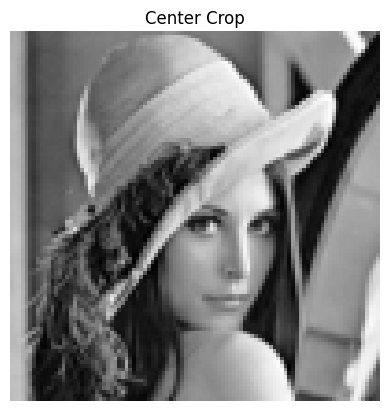

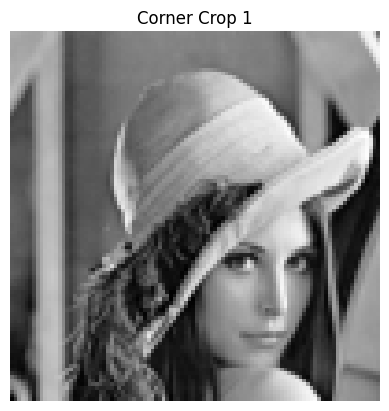

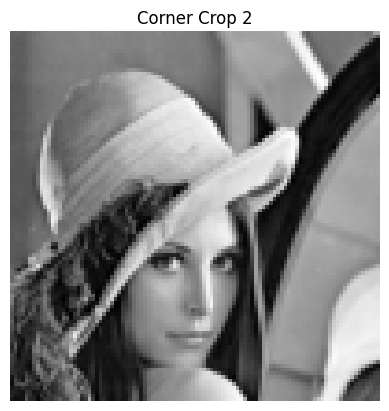

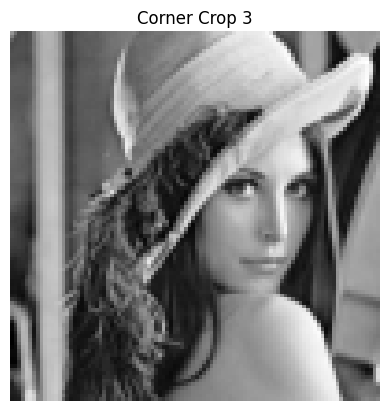

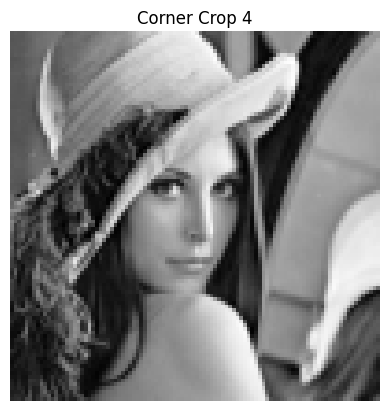

In [263]:
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch

# Fungsi untuk memuat gambar dari path
def load_image_from_path(image_path):
    image = Image.open(image_path).convert("L")  # Convert to grayscale if needed
    return T.ToTensor()(image)  # Convert PIL image to PyTorch Tensor

# Fungsi untuk menampilkan gambar
def show_image(img_tensor, title):
    img_np = img_tensor.squeeze().numpy()  # Ubah ke numpy untuk plotting
    plt.imshow(img_np, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Augmentasi: Center crop dan corner crop
def random_cropping(image_tensor):
    # Resize gambar ke ukuran lebih besar jika ingin crop di bagian tepi
    transform_resize = T.Resize((120, 120))
    resized_image = transform_resize(image_tensor)

    # Center Crop
    transform_center_crop = T.CenterCrop((100, 100))
    center_cropped_image = transform_center_crop(resized_image)

    # Corner Crops (top-left, top-right, bottom-left, bottom-right)
    crop_size = 100
    crops = []
    # Top-left crop
    crops.append(resized_image[:, :crop_size, :crop_size])
    # Top-right crop
    crops.append(resized_image[:, :crop_size, -crop_size:])
    # Bottom-left crop
    crops.append(resized_image[:, -crop_size:, :crop_size])
    # Bottom-right crop
    crops.append(resized_image[:, -crop_size:, -crop_size:])

    return center_cropped_image, crops

# Path ke gambar
image_path = "../src/lenna.jpg"  # Ganti dengan path gambar

# Load gambar dari path
image_tensor = load_image_from_path(image_path)

# Panggil fungsi untuk crop
center_crop, corner_crops = random_cropping(image_tensor)

# Menampilkan gambar hasil cropping
show_image(center_crop, "Center Crop")
for i, crop in enumerate(corner_crops):
    show_image(crop, f"Corner Crop {i+1}")
